## SFC Meteorology Obs from:
** - 2019 M2 (BSITAEPR-2A) **   
*** - 2019 M2 (BSM-2A) ***

__pyversion__==3.6   
__author__==S.Bell

In [188]:
import datetime
print("Last run {0}".format(datetime.datetime.now()))

Last run 2019-05-17 07:57:51.017723


### connecting to erddap and retrieving and basic information

In [189]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

server_url = 'http://downdraft.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url)

In [190]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='a_met'))

In [191]:
'We have {} tabledap, {} griddap, and {} wms endpoints.'.format(
    len(set(df['tabledap'].dropna())),
    len(set(df['griddap'].dropna())),
    len(set(df['wms'].dropna()))
)

'We have 4 tabledap, 0 griddap, and 0 wms endpoints.'

In [192]:
datasets = df['Dataset ID'].values
print(datasets)

['erddap_17ckitaem2a_met' 'erddap_18bsitaepr2a_met'
 'erddap_18mtitaepr1a_met' 'erddap_19bsitaepr2a_met']


In [193]:
variables = [e.get_var_by_attr(dataset_id=dataset, standard_name=lambda v: v is not None) for dataset in datasets]
print(variables)

[['longitude', 'latitude', 'air_pressure', 'wind_speed', 'northward_wind', 'air_temperature', 'eastward_wind', 'wind_from_direction', 'relative_humidity', 'time'], ['longitude', 'latitude', 'air_pressure', 'wind_speed', 'northward_wind', 'air_temperature', 'eastward_wind', 'wind_from_direction', 'relative_humidity', 'time'], ['longitude', 'latitude', 'air_pressure', 'wind_speed', 'northward_wind', 'air_temperature', 'eastward_wind', 'wind_from_direction', 'relative_humidity', 'time'], ['longitude', 'latitude', 'air_pressure', 'northward_wind', 'air_temperature', 'eastward_wind', 'relative_humidity', 'time']]


### getting Peggy Buoy (BSM-2A) Data

In [194]:
wdf = pd.read_csv('http://pavlof.pmel.noaa.gov/bell/ArgosMooring/data/TotalArgosMessage_28882.csv',
                  parse_dates=True,index_col='sampletime')

In [195]:
wdf = wdf.resample('1H').mean()

### retrieving erddap and plotting data

In [196]:
constraints = {
    'time>=': '2019-04-25T00:00:00Z',
    'time<=': str(datetime.datetime.today()),
}

variables = [
# 'wind_from_direction', 
 'air_temperature',
 'relative_humidity',
 'northward_wind', 
 'eastward_wind', 
# 'wind_speed', 
 'latitude',
 'longitude',
 'time'
]

variable_dic={}

for index,row in df.iterrows():
    info_url = e.get_info_url(dataset_id=row['Dataset ID'], response='csv')
    info = pd.read_csv(info_url)

    #print(info.head())
    print('Variables in {}:'.format(row['Dataset ID']))
    print(','.join(info.loc[info['Row Type'] == 'variable', 'Variable Name']))

    variable_dic.update({row['Dataset ID']:list(info.loc[info['Row Type'] == 'variable', 'Variable Name'])})
    

Variables in erddap_17ckitaem2a_met:
timeseries_id,time,wind_speed,northward_wind,latitude,longitude,air_pressure,relative_humidity,air_temperature,wind_from_direction,eastward_wind
Variables in erddap_18bsitaepr2a_met:
timeseries_id,time,wind_speed,northward_wind,latitude,longitude,air_pressure,relative_humidity,air_temperature,wind_from_direction,eastward_wind
Variables in erddap_18mtitaepr1a_met:
timeseries_id,time,wind_speed,northward_wind,latitude,longitude,air_pressure,relative_humidity,air_temperature,wind_from_direction,eastward_wind
Variables in erddap_19bsitaepr2a_met:
timeseries_id,latitude,longitude,time,northward_wind,air_pressure,relative_humidity,air_temperature,eastward_wind


In [197]:
from requests.exceptions import HTTPError

dfs = {}
for index,row in df.iterrows():
    if row['Dataset ID'] in ['erddap_19bsitaepr2a_met']:
        print(row['Dataset ID'])
        try:
            e = ERDDAP(server=server_url,
                protocol='tabledap',
                response='csv',
            )
            e.dataset_id=row['Dataset ID']
            e.constraints=constraints
            if row['Dataset ID'] in ['erddap_19bsitaepr2a_met']:
                e.variables=variables + ['air_pressure']
        except HTTPError:
            print('Failed to generate url {}'.format(row['Dataset ID']))
            continue
        dfs.update({row['Dataset ID']: e.to_pandas(
                                index_col='time (UTC)',
                                parse_dates=True,
                                skiprows=(1,)  # units information can be dropped.
                                )})
    

erddap_19bsitaepr2a_met


In [198]:
df=dfs['erddap_19bsitaepr2a_met']
df.columns

Index(['air_temperature', 'relative_humidity', 'northward_wind',
       'eastward_wind', 'latitude (degrees_north)', 'longitude (degrees_east)',
       'air_pressure'],
      dtype='object')

### Take care of any preliminary QC

In [199]:
#calculate windspeed and direction
df['wind_speed (m s-1)']=np.sqrt(df['northward_wind']**2 + df['eastward_wind']**2)
df['wind_from_direction (degrees true)'] = 270-np.rad2deg(np.arctan2(df['northward_wind'],
                                                                 df['eastward_wind']))

df['wind_from_direction (degrees true)'][df['wind_from_direction (degrees true)']>360] = df['wind_from_direction (degrees true)'][df['wind_from_direction (degrees true)']>360]-360


In [200]:
#eliminate unlikely wind and pressure extremes
for ds, df in dfs.items():
    df['wind_speed (m s-1)'][df['wind_speed (m s-1)']>100] = np.nan
    df['air_pressure'][df['air_pressure']<940] = np.nan
    
#Arbitrary QC points based on evaluating plot / local characteristics and not broad science boundaries
wdf.WS[wdf.WS>25] = np.nan
wdf.RH[wdf.RH<25] = np.nan
wdf.BP[wdf.BP<975] = np.nan

### Plot

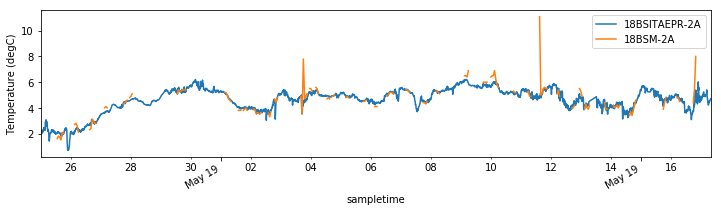

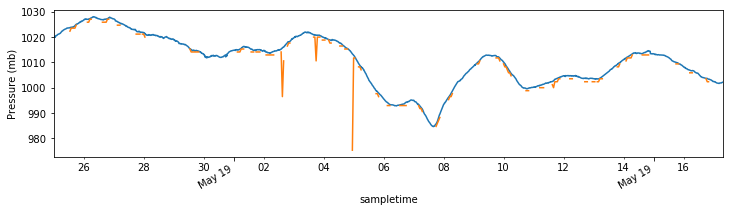

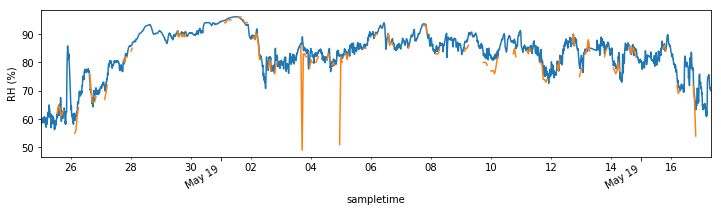

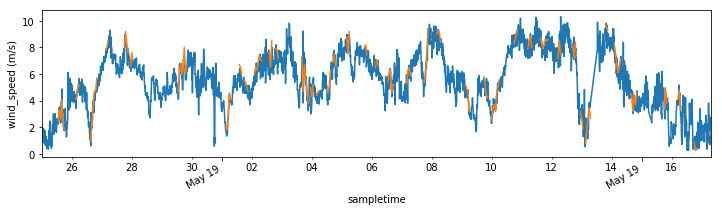

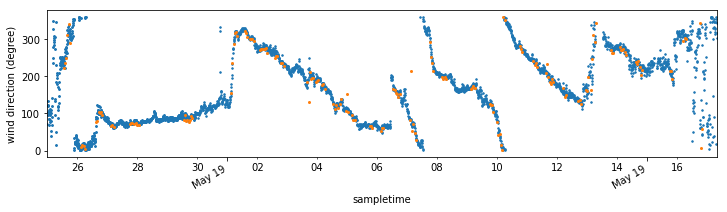

In [201]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from matplotlib.ticker import NullFormatter  # useful for `logit` scale
%matplotlib inline

fig, ax = plt.subplots(figsize=(12,3))
for ds, df in dfs.items():
    try:
        df['air_temperature'].plot(ax=ax)
        plt.ylabel('Temperature (degC)')
    except:
        pass
wdf.AT.plot(ax=ax)
plt.legend(['18BSITAEPR-2A','18BSM-2A'])
ax.xaxis.set_major_locator(DayLocator(bymonthday=[1,15]))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,2)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%b %y'))

fig, ax = plt.subplots(figsize=(12,3))
for ds, df in dfs.items():
    try:
        df['air_pressure'].plot(ax=ax)
        plt.ylabel('Pressure (mb)')
    except:
        df['air_pressure (mbar)'].plot(ax=ax)
        plt.ylabel('Pressure (mb)')
wdf.BP.plot(ax=ax)
ax.xaxis.set_major_locator(DayLocator(bymonthday=[1,15]))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,2)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%b %y'))

fig, ax = plt.subplots(figsize=(12,3))
for ds, df in dfs.items():
    try:
        df['relative_humidity'].plot(ax=ax)
        plt.ylabel('RH (%)')
    except:
        pass
wdf.RH.plot(ax=ax)
ax.xaxis.set_major_locator(DayLocator(bymonthday=[1,15]))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,2)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%b %y'))
    
fig, ax = plt.subplots(figsize=(12,3))
for ds, df in dfs.items():
    try:
        df['wind_speed (m s-1)'].plot(ax=ax)
        plt.ylabel('wind_speed (m/s)')
    except:
        pass
wdf.WS.plot(ax=ax)
ax.xaxis.set_major_locator(DayLocator(bymonthday=[1,15]))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,2)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%b %y'))

fig, ax = plt.subplots(figsize=(12,3))
for ds, df in dfs.items():
    try:
        df['wind_from_direction (degrees true)'].plot(style='.',markersize=3.0,ax=ax)
        plt.ylabel('wind direction (degree)')
    except:
        pass
wdf.WD.plot(style='.',markersize=4.0,ax=ax)
ax.xaxis.set_major_locator(DayLocator(bymonthday=[1,15]))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,2)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%b %y'))


In [202]:
wdf.tail()

,argosid,latitude,longitude,BP,AT,BV,RH,WS,WD,SR,AZ
sampletime,,,,,,,,,,,
2019-05-16 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-16 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-16 18:00:00,28882.0,56.872,164.066,1003.529412,4.4,13.0,72.0,0.9,343.074968,208.630724,271.07158
2019-05-16 19:00:00,28882.0,56.872,164.066,1002.352941,5.5,13.0,66.0,0.3,7.059156,307.455803,271.07158
2019-05-16 20:00:00,28882.0,56.872,164.066,1002.352941,8.0,14.0,54.0,0.4,59.296908,774.129790,271.07158


In [203]:
df.tail()

,air_temperature,relative_humidity,northward_wind,eastward_wind,latitude (degrees_north),longitude (degrees_east),air_pressure,wind_speed (m s-1),wind_from_direction (degrees true)
time (UTC),,,,,,,,,
2019-05-17 07:10:00+00:00,4.55,71.26,-1.3,0.3,56.873,-164.065,1002.15,1.334166,347.005383
2019-05-17 07:20:00+00:00,4.55,70.86,-0.8,0.1,56.873,-164.065,1002.15,0.806226,352.874984
2019-05-17 07:30:00+00:00,4.59,70.95,-0.5,0.8,56.873,-164.065,1002.12,0.943398,302.005383
2019-05-17 07:40:00+00:00,4.63,70.45,-0.7,0.7,56.873,-164.065,1002.16,0.989949,315.000000
2019-05-17 07:50:00+00:00,4.70,70.01,-1.0,0.3,56.873,-164.065,1002.25,1.044031,343.300756


### Next Steps

**TODO:** Plot top prawler bin/air temp for a SST/Air analysis